<a href="https://colab.research.google.com/github/wheemin-2/25-1-ESAA/blob/main/0407_HW_TextAnalysis_Practice3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge**

Challenge 목표 : 일본의 대형 온라인 쇼핑 몰인 Mercari사의 제품에 대한 가격 예측

[데이터 세트 설명]
- 제품에 대한 여러 속성 및 제품 설명 등의 텍스트 데이터로 구성
- Mercari사는 이 데이터를 기반으로 제품 예상 가격을 판매자들에게 제공하고자 함

[데이터 세트 속성]
- item_condition_id : 판매자가 제공하는 제품 상태
- shipping : 배송비 무료 여부
    - 1 : 무료 (판매자 부담)
    - 0 : 유료 (구매자 부담)
- item_description : 제품에 대한 설명
- category_name : 카테고리 명
    - '/'로 분리된 카테고리를 하나의 문자열로 나타내고 있음
    - ex. 'Men/Tops/T-shirts' : 대분류 'Men', 중분류 'Tops', 소분류 'T-shirts'
    - 전처리 과정에서 '/'를 기준으로 단어를 토큰화해 각각 별도의 피처로 저장할 예정

## **데이터 전처리**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/25-1 OB/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [3]:
# Null 값 확인
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


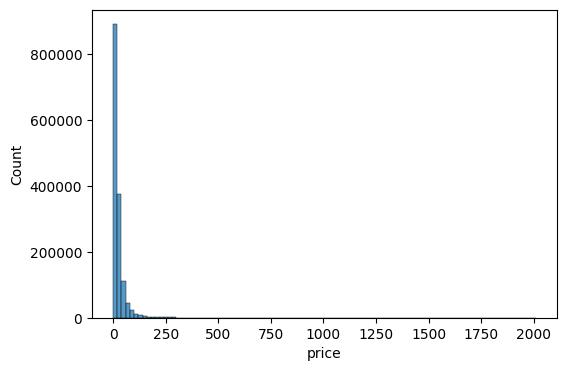

In [4]:
# Target (price) 분포도 확인
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins=100)
plt.show()

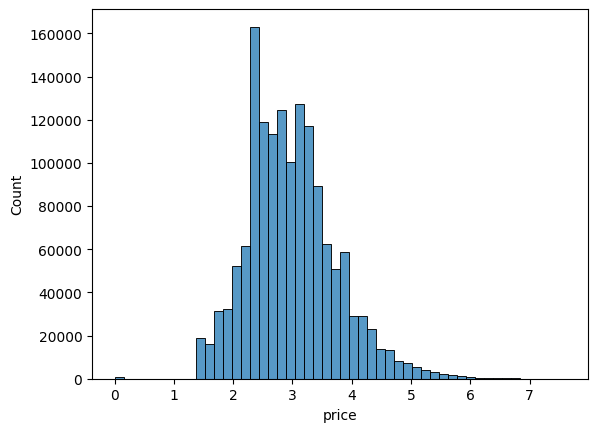

In [5]:
# right-skewed 이므로 로그 변환 진행
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

In [6]:
# 데이터 세트의 price 칼럼 : 로그 변환 진행
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

,price
0,2.397895
1,3.970292
2,2.397895


In [7]:
# shipping, item_condition_id 칼럼 살펴보기
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print()
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 shipping
0    819435
1    663100
Name: count, dtype: int64

item_condition_id 값 유형:
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


Shipping (배송비 유무) : 값이 비교적 균일

Item_condition_id (제품 상태) : 1,2,3이 주를 이룸 (*값이 의미하는 바는 캐글에 기재 X)

In [8]:
# item_description 칼럼 살펴보기
# 별도 설명이 없는 경우 'No description yet'으로 입력되어 있음
boolean_cond = mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

np.int64(82489)

In [9]:
# category_name 살펴보기
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성 (리스트로 반환)
def split_cat(category_name):
    try:
        return category_name.split('/')
    except :
        return ['Other_Null','Other_Null','Other_Null']

# 대, 중, 소 칼럼 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류 값과 유형 / 중분류, 소분류 유형 개수 확인
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수 :', mercari_df['cat_jung'].nunique())
print('소분류 개수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 개수 : 114
소분류 개수 : 871


In [10]:
# Null값 채우기
mercari_df['brand_name'] = mercari_df['brand_name'].fillna('Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna('Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna('Other_Null')

# Null값 개수 확인
mercari_df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,0
price,0
shipping,0
item_description,0
cat_dae,0
cat_jung,0


## **피처 인코딩과 피처 벡터화**

*선형 회귀의 경우 원-핫 인코딩 적용이 훨씬 선호되므로 인코딩할 피처는 모두 원-핫 인코딩 적용*

In [11]:
print('brand name의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 :', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수 : 4810
brand name sample 5건 : brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


brand_name 칼럼 확인 결과
- 대부분 명료한 문자열로 되어있으므로 별도의 피처 벡터화 형태로 만들 필요 없이 인코딩 변환을 적용!
- brand_name의 종류가 4810건으로 원-핫 인코딩으로 변환하기에 다소 많아보이지만 ML 모델 구축상 큰 문제는 없음 > 원-핫 인코딩 변환 진행 !

In [12]:
# name 칼럼 확인 (상품명)
print('name의 종류 개수 :', mercari_df['name'].nunique())
print('name sample 7건: \n', mercari_df['name'][:7])

name의 종류 개수 : 1225273
name sample 7건: 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


name 칼럼 확인 결과
- 종류가 1,225,273개로 매우 많음
- 전체 데이터가 1,482,535개임을 감안하면 개별적으로 거의 고유한 상품명을 가지고 있음
- 유형이 매우 많고, 적은 단어 위주의 텍스트 형태로 되어있음 > Count 기반 피처 벡터화 변환 적용

category_name : 전처리를 통해 cat_dae, cat_jung, cat_so 칼럼으로 분리됨 > 원-핫 인코딩 적용

shipping : 0,1 두 가지 유형의 값 > 원-핫 인코딩 적용

item_condition_id : 상품의 상태, 1~5까지 다섯 가지 유형의 값을 가짐 > 원-핫 인코딩 적용

In [13]:
# item_description : 상품에 대한 간단한 설명
pd.set_option('max_colwidth', 200)

# ite_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.71139703278507


,item_description
0,No description yet
1,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.


item_description 칼럼 확인 결과
- 평균 문자열이 145자로 비교적 큼 > TF-IDF 변환 적용!

In [14]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorication shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorication shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


CountVectorizer, TfidfVectorizer가 fit_transform()을 통해 반환하는 데이터는 **희소 행렬** 형태

희소 행렬 객체 변수인 X_name과 X_descp를 새로 결합해 새로운 데이터 세트로 구성해야하고, 앞으로 인코딩 될 칼럼들도 X_name, X_descp와 결합되어 ML 모델을 실행하는 기반 데이터 세트로 재구성 되어야 함

따라서 인코딩 대상 칼럼들도 밀집 행렬 형태가 아닌 **희소 행렬** 형태로 인코딩을 적용한 뒤, 함께 결합 진행!!
- 결합은 `Scipy.sparse` 모듈의 `hstack()` 함수 사용

*사이킷런에서의 원-핫 인코딩*
- 사이킷런은 원-핫 인코딩을 위해 `OneHotEncoder`와 `LabelBinarizer` 클래스를 제공
- 이 중 `LabelBinarizer` 클래스는 희소 행렬 형태의 원-핫 인코딩 변환을 지원함
    - 생성 시 sparse_out = True로 설정

In [15]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df ['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [16]:
# 생성된 인코딩 데이터 세트 확인
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


인코딩 변환 결과
- CSR 형태로 변환된 csr_matrix 타입
- brand_name 칼럼 : 유형이 4810개였기 때문에 4810개의 인코딩 칼럼을 가지게 됨
- X_cat_so : 871개의 인코딩 칼럼을 가짐

인코딩 칼럼이 매우 많이 생겼지만, 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터의 매우 많은 칼럼과 함께 결합되므로 크게 문제될 것은 없음

In [17]:
# hstack으로 모두 결합
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# 인코딩과 벡터화를 수행한 데이터 세트 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
# 추후 다양한 모델을 적용하므로 그때마다 다시 결합해 사용
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


0

## **릿지 회귀 모델 구축 및 평가**

평가 지표 : RMSLE
- RMSLE : 오류값에 로그를 취해 RMSE를 구하는 방식
- 낮은 가격(price)보다 높은 가격에서 오류가 발생할 경우 오류 값이 더 커지는 것을 억제하기 위해 도입

[RMSLE 수식]

![rmsle](https://blog.kakaocdn.net/dn/wmaDu/btrBfJWzJBK/JcCy2FmRznLUvfupX5KxdK/img.png)

In [18]:
def rmsle(y, y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return  np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

# 원본 데이터는 log1p로 변환되었으므로 expm1으로 원복 필요
def evaluate_org_price(y_test, preds):
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)

    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [19]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
    # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
    X = hstack(matrix_list).tocsr()

    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'],
                                                        test_size=0.2, random_state=156)

    # 모델 학습 및 예측
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    del X, X_train, X_test, y_train
    gc.collect()

    return preds, y_test

상품 가격 예측에 item_description과 같은 텍스트 형태의 속성이 얼마나 영향을 미치는지 확인

item_description 속성의 피처 벡터화 데이터가 포함되지 않았을 때와 포함 되었을 때의 예측 성능을 비교해보자!

In [20]:
linear_model = Ridge(solver='lsqr', fit_intercept = False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:', evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.4983990938999374
Item Description을 포함한 rmsle 값: 0.4680432471796771


Item Description을 포함했을 때 rmsle 값이 감소함 >> item_description 영향이 중요하다!

## **LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가**

LightGBM을 이용해 회귀를 수행한 뒤 예측값을 구한 후, 릿지 모델 예측값과 앙상블 방식으로 섞어 최종 회귀 예측값 평가 진행

In [21]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

#lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
#n_estimators=200 이 너무 오래걸려서 n_estimators=100으로 낮춰서 실행
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.5, num_leaves=125, random_state=156)  # 1시간 40분 소요
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:', evaluate_org_price(lgbm_preds, y_test))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2849.050683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1068323
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 65338
[LightGBM] [Info] Start training from score 2.979514


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM rmsle 값: 0.4650417323016895


In [22]:
# 앙상블 진행
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:', evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4505807414895025
